In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = 'data/Amazon/'

In [5]:
ls {PATH}

subm.csv   test-jpg-additional/     test-jpg-additional.tar.7z  train-jpg/
test-jpg/  test-jpg-additional.tar  tmp/                        train_v2.csv


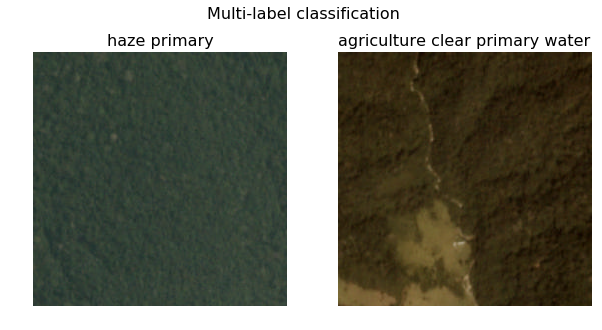

In [6]:
list_paths = [f"{PATH}train-jpg/train_3.jpg", f"{PATH}train-jpg/train_4.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [7]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [8]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [20]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg-additional')

In [21]:
data = get_data(256)

In [22]:
x,y = next(iter(data.val_dl))

In [23]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [24]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

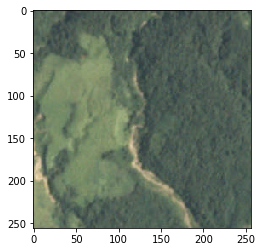

In [25]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [26]:
sz=64

In [27]:
data = get_data(sz)

In [28]:
data = data.resize(int(sz*1.3), 'tmp')

In [29]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [20]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   f2                          
    0      0.220537   0.348087   0.799661  



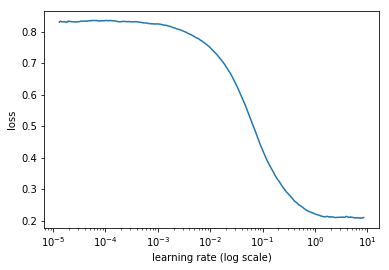

In [21]:
learn.sched.plot()

In [22]:
lr = 0.2

In [23]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.150002   0.135038   0.881202  
    1      0.140684   0.129512   0.886908                    
    2      0.136831   0.127485   0.888896                    
    3      0.141362   0.126969   0.888286                    
    4      0.134713   0.125206   0.890652                    
    5      0.131862   0.123305   0.892672                    
    6      0.12938    0.122698   0.894108                    



[array([0.1227]), 0.8941080026803652]

In [24]:
lrs = np.array([lr/9,lr/3,lr])

In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.118931   0.108835   0.909723  
    1      0.113978   0.103841   0.9133                      
    2      0.108106   0.101824   0.913808                    
    3      0.1112     0.103839   0.911618                    
    4      0.10265    0.100668   0.914832                    
    5      0.099645   0.09779    0.918439                     
    6      0.098643   0.097594   0.916769                     



[array([0.09759]), 0.916769295756348]

In [26]:
learn.save(f'{sz}')

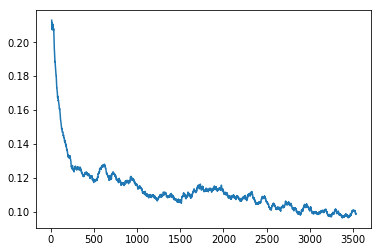

In [27]:
learn.sched.plot_loss()

In [28]:
sz=128

In [29]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.09957    0.097284   0.916437  
    1      0.099257   0.096476   0.916066                     
    2      0.096194   0.095998   0.917493                     
    3      0.096884   0.09548    0.916893                     
    4      0.094645   0.094415   0.919033                     
    5      0.094793   0.094132   0.919267                     
    6      0.094349   0.093639   0.919714                     



[array([0.09364]), 0.9197140754637129]

In [30]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.0939     0.087942   0.926407  
    1      0.094859   0.08775    0.927589                     
    2      0.088686   0.086424   0.927645                     
    3      0.094323   0.089167   0.924301                     
    4      0.089973   0.086529   0.928359                     
    5      0.084795   0.085338   0.928066                     
    6      0.08517    0.085059   0.928454                     



In [31]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [32]:
f2(preds,y)

0.9287534628181083

In [33]:
multi_preds,y = learn.TTA(is_test=True)

NameError: name 'log_preds' is not defined

In [32]:
probs = np.mean(np.exp(multi_preds),0)

In [33]:
multi_preds

array([[[0.0312 , 0.00009, 0.00206, ..., 0.00165, 0.00022, 0.18868],
        [0.00497, 0.00002, 0.00006, ..., 0.00022, 0.00006, 0.00319],
        [0.76623, 0.00138, 0.02131, ..., 0.00532, 0.01551, 0.02647],
        ...,
        [0.6795 , 0.00023, 0.02285, ..., 0.00131, 0.00247, 0.74135],
        [0.30557, 0.00011, 0.00282, ..., 0.00142, 0.00139, 0.01254],
        [0.79451, 0.00205, 0.00952, ..., 0.00172, 0.00285, 0.13509]],

       [[0.02076, 0.00008, 0.00092, ..., 0.00109, 0.00012, 0.48276],
        [0.00342, 0.00002, 0.00004, ..., 0.00019, 0.00004, 0.00201],
        [0.78303, 0.00145, 0.02477, ..., 0.00642, 0.01976, 0.02421],
        ...,
        [0.66708, 0.00029, 0.01941, ..., 0.00151, 0.00207, 0.7836 ],
        [0.35633, 0.00013, 0.00466, ..., 0.00134, 0.00203, 0.01677],
        [0.88274, 0.00141, 0.0117 , ..., 0.00146, 0.00412, 0.14257]],

       [[0.03029, 0.00008, 0.00105, ..., 0.00115, 0.00017, 0.4102 ],
        [0.00678, 0.00002, 0.00008, ..., 0.0002 , 0.00007, 0.00472],
    

In [34]:
multi_preds = learn.predict(is_test=True)

In [35]:
multi_preds.shape

(20522, 17)

In [36]:
preds = np.argmax(multi_preds, axis=1)
probs = np.exp(multi_preds[:,1])

In [37]:
preds

array([12, 12, 12, ..., 12, 12, 12])

In [38]:
probs

array([1.00009, 1.00002, 1.00139, ..., 1.00023, 1.00011, 1.00205], dtype=float32)

In [51]:
class_preds = [data.classes[index_pred] for index_pred in preds]

In [52]:
fnames_nopath = [fname[20:-4] for fname in data.test_ds.fnames]

In [53]:
fname_preds = list(zip(fnames_nopath, class_preds))

In [54]:
df = pd.DataFrame(fname_preds)

In [55]:
df.columns = ["image_name", "tags"]

In [56]:
df.head()

,image_name,tags
0,file_2096,primary
1,file_19729,primary
2,file_423,primary
3,file_401,primary
4,file_7286,primary


In [58]:
df.to_csv(f'{PATH}subm.csv', index=False)

In [57]:
df.to_csv(f'{PATH}subm1.csv', index=False)

In [30]:
learn.load(f'{sz}')

In [31]:
multi_preds,y = learn.TTA(is_test=True)